# Binomial + Beta, Predictive Check

We check whether the model works or not.

In [1]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [2]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

## With Binomial Likelihood

In [3]:
def model_Binomial(a, b, N, z=None):
    theta = numpyro.sample('theta', dist.Beta(a, b))
    obs = numpyro.sample('obs', dist.Binomial(total_count=N, probs=theta), obs=z)

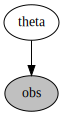

In [4]:
numpyro.render_model(model_Binomial, model_args=(100,100,20,17))

## Run MCMC inference

In [5]:
kernel = NUTS(model_Binomial)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)

#
a,b = 100, 100  # prior model
N, z = 20, 17   # observation from binomial 
#
mcmc.run(rngkey, a=b, b=b, N=N, z=z)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:06<00:00, 921.80it/s, 3 steps of size 9.10e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.53      0.03      0.53      0.48      0.59   1587.93      1.00

Number of divergences: 0


In [6]:
samples_binom = mcmc.get_samples()
samples = samples_binom
samples

{'theta': DeviceArray([0.540192  , 0.5332061 , 0.53641796, ..., 0.5475946 ,
              0.54662555, 0.5395682 ], dtype=float32)}

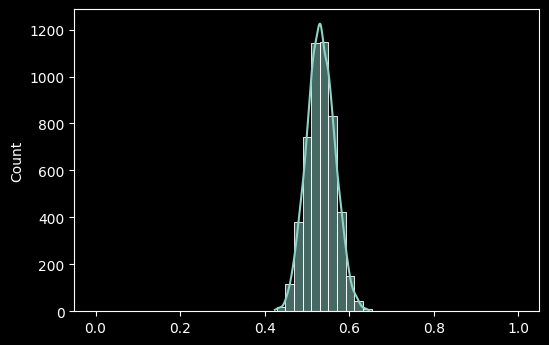

In [7]:
x = np.linspace(0, 1, 50)
sns.histplot(samples['theta'], kde=True, bins=x, );

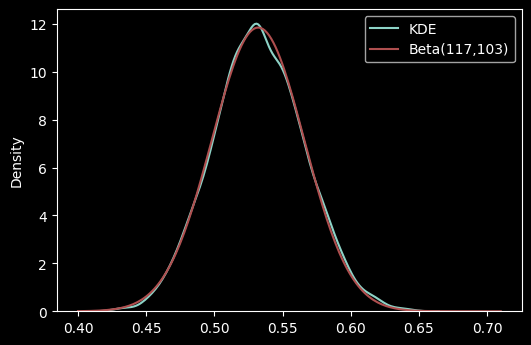

In [8]:
x = np.linspace(.4, .71, 200)
apost, bpost = a+z, b+N-z
pdf = stats.beta.pdf(x, a=apost, b=bpost) # PDF of Beta

ax = sns.kdeplot(samples['theta'])        # KDE of samples
# ax.set(label='KDE')
ax.plot(x, pdf, '-', c='#af4f4f')
ax.legend(['KDE', f'Beta({apost},{bpost})']);

In [9]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
hdi = (s[low_index].item(), s[high_index].item())
print(f'hdi: [{hdi[0]:.3f}, {hdi[1]:.3f}]')

hdi: [0.471, 0.596]


Mode of Beta(a,b):

$$
    mode = \frac{a-1}{a+b-2} \quad\mbox{for}\quad a,b > 1
$$

In [10]:
# Mode/Peak of the density approximation
import scipy 
kde = scipy.stats.gaussian_kde(s)  # density function approximation
x = np.linspace(0, 1, 1200)
pdfx = kde.evaluate(x) # function values at x
max_index = pdfx.argmax()
print(f'The KDE mode is at     {x[max_index]:.3f}')

mode = (apost - 1) / (apost + bpost - 2)
print(f'Theoretical mode is at {mode}')

The KDE mode is at     0.530
Theoretical mode is at 0.5321100917431193


hdi:  (0.47107067704200745, 0.5958127975463867)


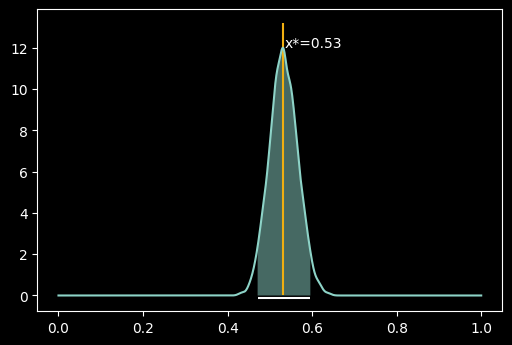

In [11]:
plt.plot(x, pdfx);
plt.vlines(x=x[max_index], ymin=0, ymax=pdfx[max_index]*1.1, colors='#f1af11');
plt.text(x=x[max_index]*1.01, y=pdfx[max_index], s=f'x*={x[max_index]:.3}');
#
plt.hlines(y=-.1, xmin=s[low_index], xmax=s[high_index])
pdfs = kde.evaluate(s)
plt.fill_between(s[low_index:high_index+1], pdfs[low_index:high_index+1], alpha=.5);
#
print('hdi: ', hdi)

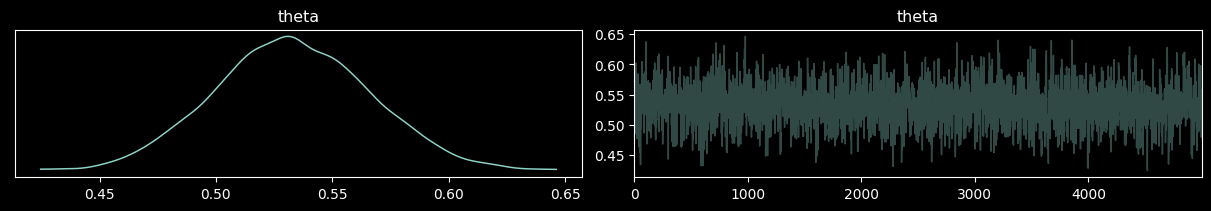

In [12]:
import arviz
arviz.plot_trace(samples);

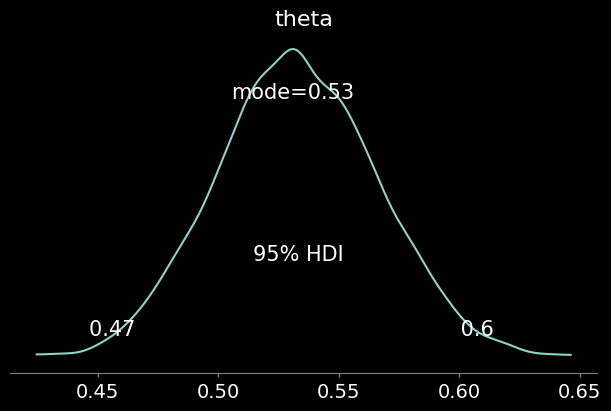

In [13]:
arviz.plot_posterior(samples, point_estimate='mode', bins=x, hdi_prob=.95);

## Posterior Prediction

In [14]:
s1 = samples['theta'][100]  # get a sample of parameter theta
y = stats.binom(n=N, p=s1).rvs(1)  # sample an observation
print('predictive obs: ', y, 'with theta: ', s1)

predictive obs:  [12] with theta:  0.6374916


In [15]:
# we may generate many predictive samples
y = stats.binom(n=N, p=s1).rvs(10000)

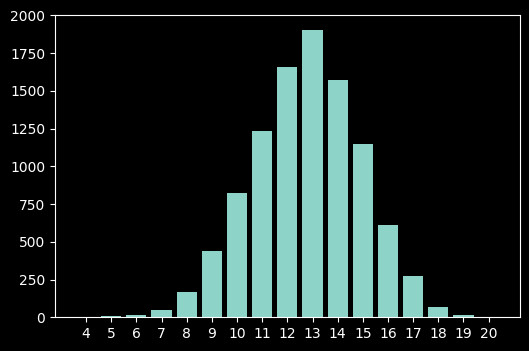

In [16]:
obs, count = np.unique(y, return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

### Posterior Predictive Check

Here we generate one obs sample for each of the posterior parametr samples

In [17]:
ypost = stats.binom(n=N, p=samples['theta']).rvs()

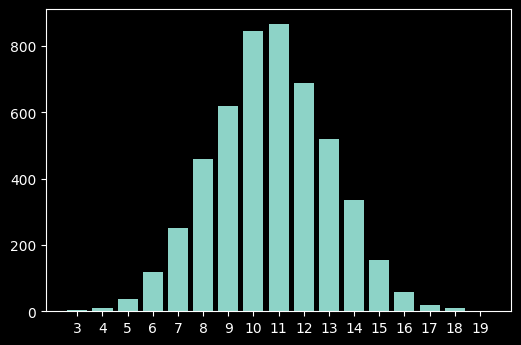

In [18]:
obs, count = np.unique(ypost, return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

- The observation z could have been 10 or 11 or even 6 instead of 17, the actual obs, according to this posterior predictive observation distribution.

### numpyro.infer.Predictive

In [19]:
# define a predictor
predictive = numpyro.infer.Predictive(model_Binomial, posterior_samples=samples)

In [20]:
# run the predictor, each run will yield a different result
rngkey, subkey = jax.random.split(rngkey)
pred = predictive(rngkey, 100, 100, 20)

In [21]:
pred

{'obs': DeviceArray([ 9, 11,  8, ..., 12, 12,  7], dtype=int32)}

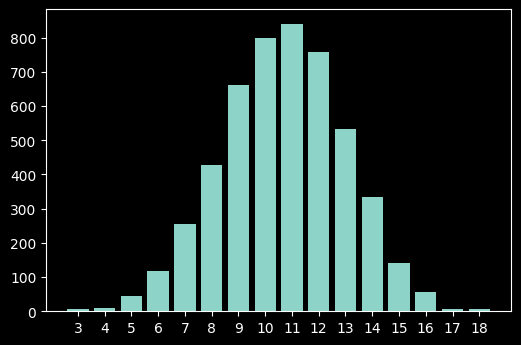

In [22]:
obs, count = np.unique(pred['obs'], return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

## Prior Predictive Check

### Direct Sampling

In [23]:
ns = 3000
theta = stats.beta(100,100).rvs(ns)
obs = stats.binom(n=N, p=theta).rvs()
theta.shape, obs.shape

((3000,), (3000,))

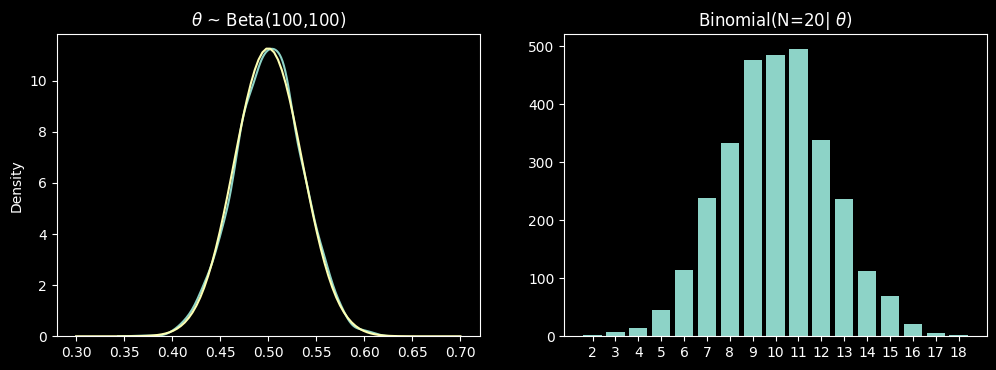

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
#
#sns.histplot(theta, bins=40, kde=True, ax=ax1);
sns.kdeplot(theta, ax=ax1);  # kde should look very same in this case
x = np.linspace(.3, .7, 100)
ax1.plot(x, stats.beta(100,100).pdf(x))
ax1.set(title='$\\theta$ ~ Beta(100,100)')
#
uniq, count = np.unique(obs, return_counts=True)
ax2.bar(uniq, count)
ax2.set(xticks=uniq, title=f'Binomial(N={N}| $\\theta$)');

### numpyro.infer.Predictive

In [25]:
# define, but with model only
predictive = numpyro.infer.Predictive(model_Binomial, num_samples=2999)

In [26]:
# run the predictor, each run will yield a different result
rngkey, subkey = jax.random.split(rngkey)
pred = predictive(rngkey, 100, 100, 20)

In [27]:
pred

{'obs': DeviceArray([ 8,  9,  9, ..., 11, 10,  6], dtype=int32),
 'theta': DeviceArray([0.51668954, 0.5014436 , 0.5152127 , ..., 0.4815745 ,
              0.48292324, 0.53294075], dtype=float32)}

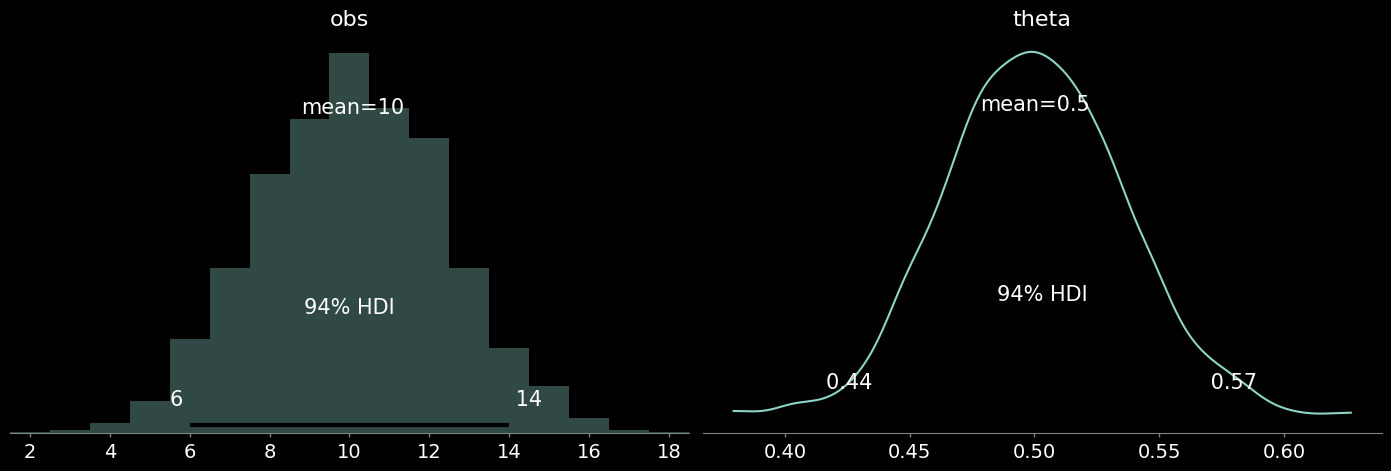

In [28]:
import arviz
arviz.plot_posterior(pred);  #

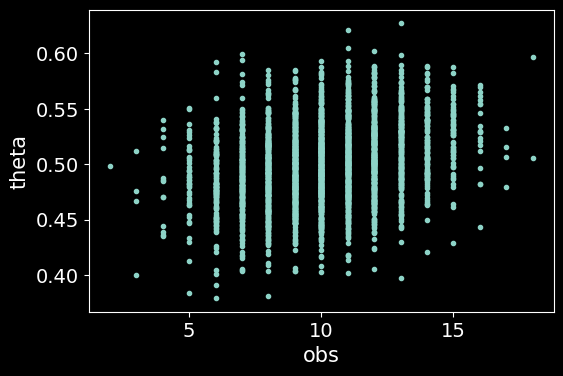

In [29]:
import arviz
arviz.plot_pair(pred); # not a posterior this time.

#### With Uniform Prior

In [30]:
# run the predictor, each run will yield a different result
rngkey, subkey = jax.random.split(rngkey)
pred = predictive(rngkey, 1, 1, 20)       # Flat Prior

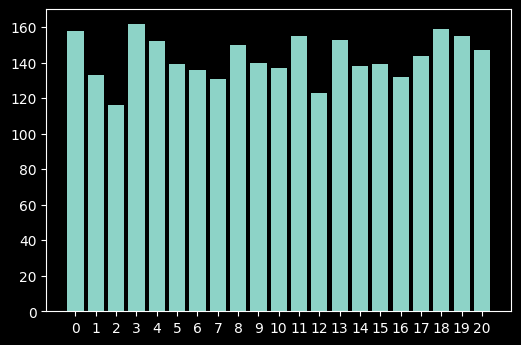

In [31]:
obs, count = np.unique(pred['obs'], return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

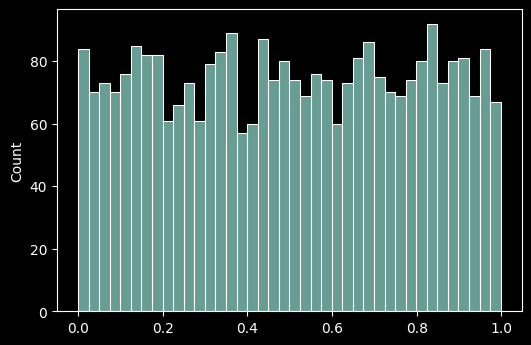

In [32]:
sns.histplot(pred['theta'], bins=40);

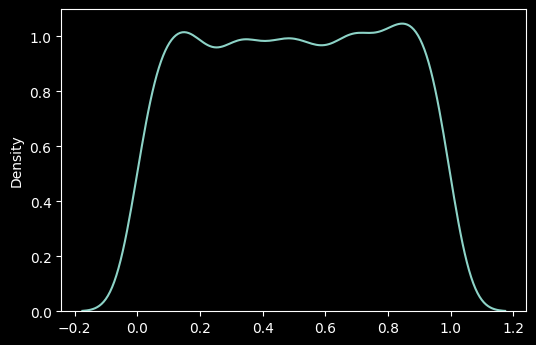

In [33]:
sns.kdeplot(pred['theta']);  # no useful plot

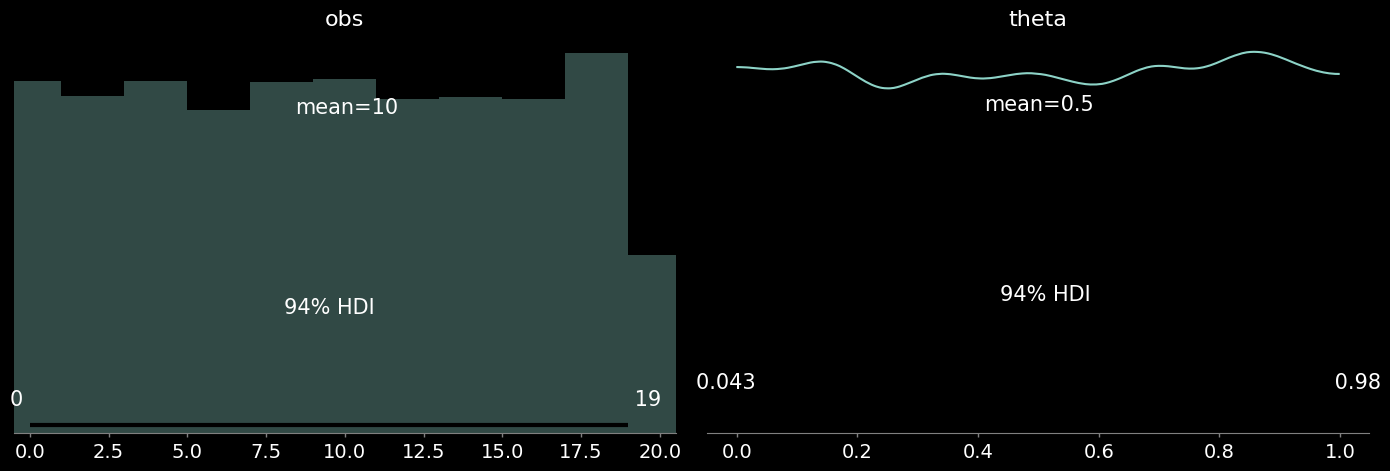

In [34]:
import arviz
arviz.plot_posterior(pred);  # look strange too

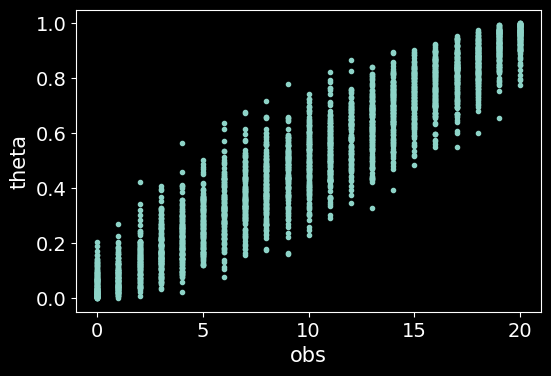

In [35]:
arviz.plot_pair(pred); # useful, note that it is not a posterior this time.

---

**Question**

1. Why is the mode at 11?
2. Plot a prior predictive sampling (observation) distribution. The prior distribution was Beta(100,100) and the sampling distribution was chosen to be Binomial with N=20.
3. See what happens in predictive prior and posterior sampling histograms when the prior is chosen to be Beta(10, 10), N=20, z=17.
4. Repeat for Beta(100, 100), N=200, z=170.
5. Repeat for Beta(100, 30) as the prior, and
    1. N=200, z=170.
    2. N=20, z=17

End.

In [36]:
!jupyter nbconvert Ch.6.Bernoulli_beta_Predictive.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Ch.6.Bernoulli_beta_Predictive.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 462863 bytes to Ch.6.Bernoulli_beta_Predictive.pdf
